In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("data/Houses.csv", encoding='cp1250', index_col=0)
df.shape

(23764, 10)

### Let's inspect the data

In [3]:
df.head()

,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,Grunwald,Poznań,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


In [4]:
df.sample(n=5)

,address,city,floor,id,latitude,longitude,price,rooms,sq,year
3331,Wzgórza Krzesławickie Lubocka,Kraków,0.0,22316.0,50.094826,20.083741,599000.0,3.0,54.0,2019.0
11715,Swoszowice Zakopiańska,Kraków,1.0,28532.0,49.998824,19.919951,619000.0,4.0,88.0,1960.0
1366,Białołęka ul. Głębocka,Warszawa,0.0,10223.0,52.323468,21.067092,315000.0,2.0,38.0,2020.0
22398,Ursus Gołąbki Warszawska,Warszawa,3.0,17764.0,51.174411,18.395041,420000.0,2.0,38.9,2000.0
20647,Mistrzejowice os. Oświecenia,Kraków,3.0,20016.0,50.093936,19.989742,369000.0,2.0,40.5,2000.0


In [5]:
## Apparently there are no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23764 entries, 0 to 23763
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    23764 non-null  object 
 1   city       23764 non-null  object 
 2   floor      23764 non-null  float64
 3   id         23764 non-null  float64
 4   latitude   23764 non-null  float64
 5   longitude  23764 non-null  float64
 6   price      23764 non-null  float64
 7   rooms      23764 non-null  float64
 8   sq         23764 non-null  float64
 9   year       23764 non-null  float64
dtypes: float64(8), object(2)
memory usage: 2.0+ MB


In [6]:
## This operation doesn't require from us manual checking if the number of Non-Null columns is the same as the number of entries
## So let's put it here to make our lifes easier(if there would be more features then boolean masking would be applicable)
df.isna().sum()

address      0
city         0
floor        0
id           0
latitude     0
longitude    0
price        0
rooms        0
sq           0
year         0
dtype: int64

In [7]:
## By now we can drop id column because it's just the indentifier(it is said so in the description of the dataset) but we can also just check the ratio
## of unique values to all values for this feature and be sure
print(df.id.nunique() / df.id.size)

1.0


In [8]:
df = df.drop(columns=["id"])

array([[<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'sq'}>],
       [<AxesSubplot:title={'center':'year'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

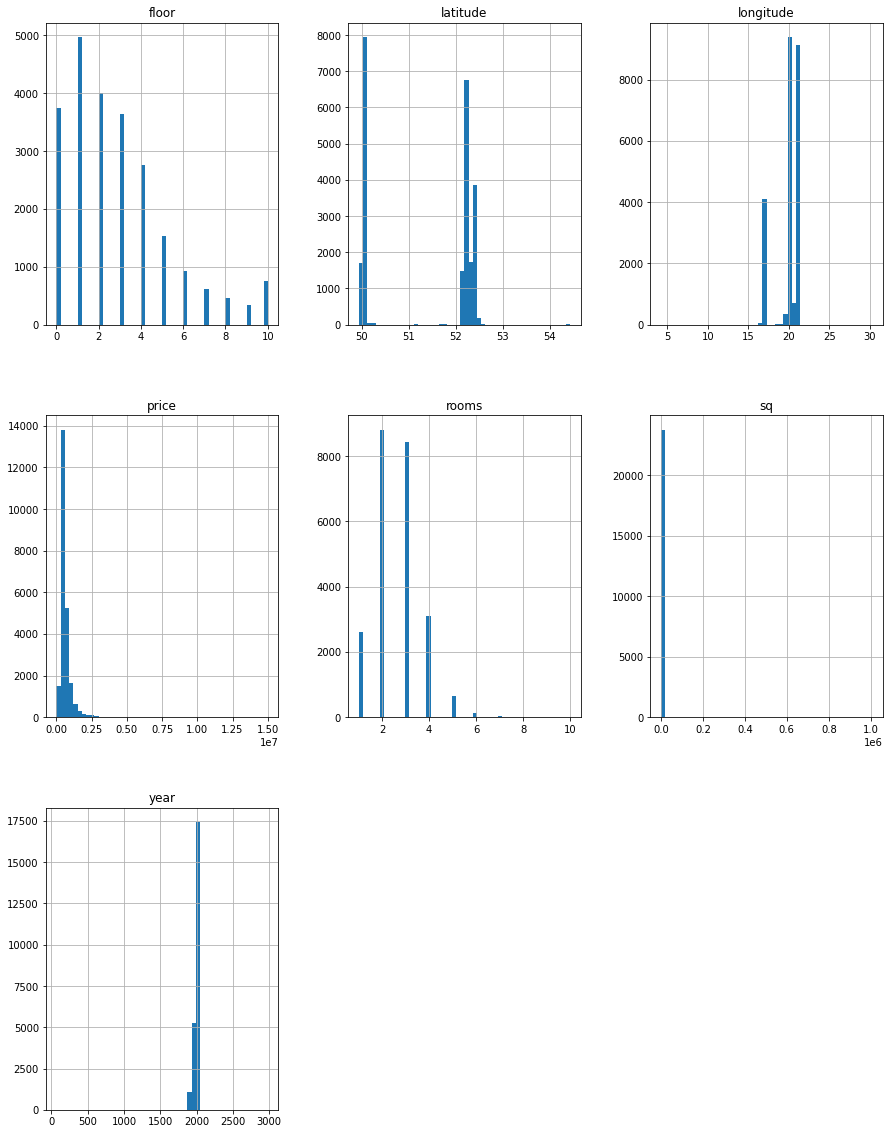

In [9]:
df.hist(bins=50, figsize=(15,20))

In [10]:
## From the visualization above we can conclude that variables floor, rooms can be treated as categorical/ordinal variables and also
## that there are quite a few outliers "(see the x range of the "sq", "year" or even "price")
## We can also see that latitude and and longitude have 3 visible peaks which probably signifies that the houses in the dataset are to be localized
## mostly in 3 cities (Let's inspect number of unique values for each feature)

In [11]:
df.nunique()

address      5419
city            3
floor          11
latitude     2768
longitude    2768
price        7284
rooms          10
sq           5019
year          168
dtype: int64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

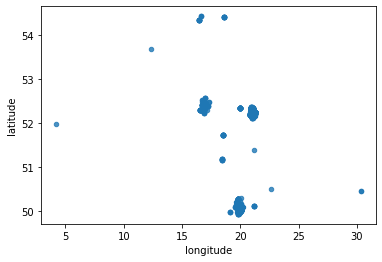

In [12]:
## Interestingly I see that some geographical locations are off by a huge amounts
## So the outlier dropping of "sq", "year" and "price" will have to w8 a little bit more, let's tackle geography first 

## Let's write a function that will discard the rows that differ from the geographical location of the given cities in the dataset
## by some n amount (First option, need to gather data about geographical locations of given cities)

## The second option is to standardize the geographical locations and drop the ones that are some n(might be a fraction)
## standard deviations away

df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.8)

In [13]:
## I know that my visualization isn't top notch but it's enough to see that's something wrong when you have only 3 cities in your dataset

In [14]:
df['city'].value_counts()

Warszawa    9851
Kraków      9764
Poznań      4149
Name: city, dtype: int64

In [15]:
## Compute mean and standard deviation of geographical locations of the given cities
groupped_df = df.groupby("city")[["longitude", "latitude"]].agg(["mean", "std"])
groupped_df

longitude             latitude          
               mean       std       mean       std
city                                              
Kraków    19.956403  0.224703  50.072127  0.207642
Poznań    16.923472  0.081897  52.407303  0.080458
Warszawa  21.005520  0.214281  52.231282  0.089208

In [16]:
## define function for data manipulation
## This function returns the standard deviation from the mean
def geographical_location(df_, groupped_df_):
    df_ = df_.copy()
    ## vectorized solution (mostly)
    unique_columns = list(set(groupped_df_.columns.droplevel(1)))
    for name in groupped_df_.index:
        bool_mask = df_["city"] == name
        df_.loc[bool_mask, unique_columns] -= groupped_df_.loc[name, (slice(None), "mean")].droplevel(1)
        df_.loc[bool_mask, unique_columns] /= groupped_df_.loc[name, (slice(None), "std")].droplevel(1)
        
    return df_

In [17]:
## Now we will define a function that will return a boolean mask for locations that are n standard deviations from the mean(fractions are also allowed)
def get_bool_mask_location(df_, n=1):
    bool_mask = pd.Series(np.zeros(df_.shape[0]).astype(bool))
    for name in df_:
        bool_mask |= df_[name].abs() >= n
    return bool_mask

In [18]:
standard_deviations_off = df[["city", "latitude", "longitude"]].pipe(geographical_location, groupped_df).drop(columns=["city"])
standard_deviations_off

,latitude,longitude
0,-0.110299,0.062197
1,0.207297,0.473053
2,-0.024863,-0.161896
3,-0.038412,-0.499776
4,-0.213625,-0.153489
...,...,...
23759,0.526317,0.316689
23760,-0.506376,-0.266388
23761,-0.123762,0.469700
23762,-0.230664,0.014088


In [19]:
standard_deviations = 2
bool_mask_location = standard_deviations_off.pipe(get_bool_mask_location, standard_deviations)
amount_off = bool_mask_location.sum()
print("There are {} entries that are off by more than {} standard deviations from the mean".format(amount_off, standard_deviations))

There are 135 entries that are off by more than 2 standard deviations from the mean


In [20]:
standard_deviations_off.loc[bool_mask_location]

,latitude,longitude
84,-0.142550,3.624120
256,-11.835446,-12.188867
500,-30.227715,26.511746
503,0.207866,-2.475871
533,-1.333389,-4.301936
...,...,...
22398,-11.847296,-12.182522
22946,-1.333389,-4.301936
22971,24.394364,-11.277766
23265,0.179721,5.303234


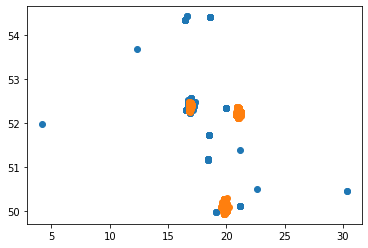

In [21]:
## Let's draw them now
import matplotlib.pyplot as plt

invalid_locations = df[bool_mask_location]
valid_locations = df[~bool_mask_location]

plt.scatter(x=invalid_locations.loc[:, "longitude"], y=invalid_locations.loc[:, "latitude"], label="Outlier")
plt.scatter(x=valid_locations.loc[:, "longitude"], y=valid_locations.loc[:, "latitude"], label="Valid value")
plt.show()

## Now it looks better, although still, the visualizations could have been better, but now we visibly see the three cities

In [22]:
## Let's get rid of those outliers
df = df[~bool_mask_location].reset_index(drop=True)

In [23]:
df

,address,city,floor,latitude,longitude,price,rooms,sq,year
0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,Praga-Południe Grochowska,Warszawa,3.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,Krowodrza Czarnowiejska,Kraków,2.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,Grunwald,Poznań,2.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0
...,...,...,...,...,...,...,...,...,...
23624,Stare Miasto Naramowice,Poznań,0.0,52.449649,16.949408,543000.0,4.0,77.00,2020.0
23625,Włochy,Warszawa,4.0,52.186109,20.948438,910000.0,3.0,71.00,2017.0
23626,Nowe Miasto Malta ul. Katowicka,Poznań,0.0,52.397345,16.961939,430695.0,3.0,50.67,2022.0
23627,Podgórze Duchackie Walerego Sławka,Kraków,6.0,50.024231,19.959569,359000.0,2.0,38.86,2021.0


In [24]:
## Now finally let's get rid of the first spotted outliers and see the how the "proper" histogram for "price", "sq" and "year" will look like

In [25]:
def delete_outliers_quartile(ser, lower_q, upper_q):
    lower_bound, upper_bound = ser.quantile([lower_q, upper_q])
    minimum, maximum = ser.min(), ser.max()
    
    format_info_1 = "The non outlier values for {} are between [{}, {}]"
    format_info_2 = "Values that are discarded for column {} [{}, {}) and ({}, {}]"
    
    print(format_info_1.format(ser.name, lower_bound, upper_bound))
    print(format_info_2.format(ser.name, *(minimum, lower_bound), *(upper_bound, maximum)))
    print()
    
    return (ser >= lower_bound) & (ser <= upper_bound)

The non outlier values for sq are between [20.0, 168.1296000000002]
Values that are discarded for column sq [8.8, 20.0) and (168.1296000000002, 1007185.0]

The non outlier values for year are between [1900.0, 2022.0]
Values that are discarded for column year [70.0, 1900.0) and (2022.0, 2980.0]

The non outlier values for price are between [235000.0, 2741712.8400000343]
Values that are discarded for column price [5000.0, 235000.0) and (2741712.8400000343, 15000000.0]



array([[<AxesSubplot:title={'center':'sq'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'price'}>, <AxesSubplot:>]],
      dtype=object)

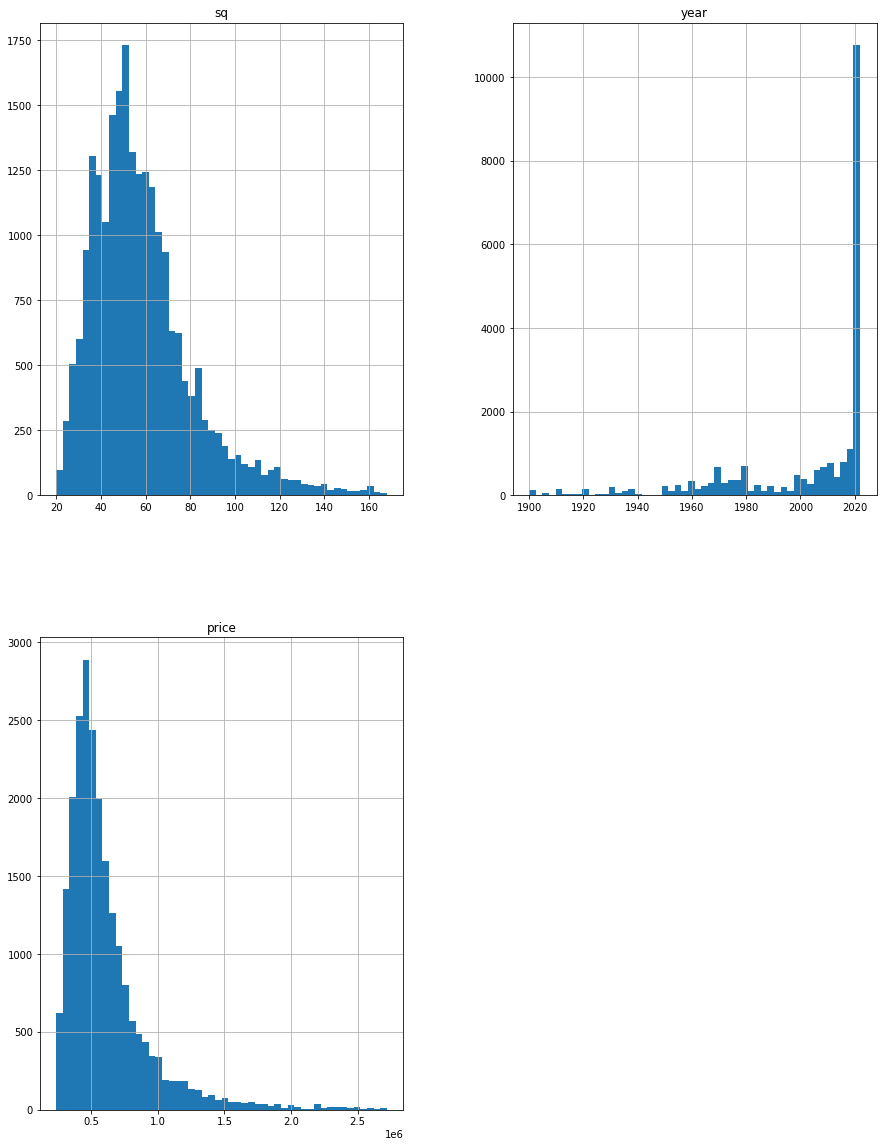

In [26]:
## Let's use pandas chaining for outliers removal

non_outliers = (df[["sq", "year", "price"]]
 .apply(lambda ser: ser.pipe(delete_outliers_quartile, 0.01, 0.99))
 .all(axis=1)
)
df[["sq", "year", "price"]][non_outliers].hist(bins=50, figsize=(15, 20))

## Obviously the sq that are 168+ might be considered as outliers but they definitely should not be dropped
## as it is reasonable to assume that such values are not caused by some error,
## although the value of 1,007,185 sq meters seems quite absurd, therefore I think dropping such huge values is explainable
## When it comes to the lower bound I think that in Poland the flat should be 25 sq meters + to be even considered as such 
## "https://www.prawo.pl/biznes/minimalny-metraz-mieszkan-juz-od-2018-r,154420.html",
## so I guess that staying at 20 sq meters lower bound should be ok
## After thorough consideration I will assume proper values to be between [20, 500] sq meters

## When it comes to year we can see two extreme values at the ends of distribution year 78 and year 2980 which both seem quite unreasonable
## I think that the range between [1800, 2030] should suffice our considerations 
## Note: I know that the houses from 2030 do not exist yet, but they definitely can be in planned to be build, therefore I'm leaving
## the values that are "slightly" higher than the year of obtaining the data

## And when it comes to our target variable(price) we will let it be as it is,
## because the value of 15,000,000 pln doesn't seem to be impossible although further investigation
## will be needed for the lower bound part of our data (5000 pln for a flat seems at the very least quite untrustworthy)

In [27]:
## Now let's inspect the price outliers that are below 100000 pln (they seem quite unlikely to occur in real world)
## Let's create a $/sq meter column so we get better insight into the data
## I think that also adding this column to the general DataFrame will also be beneficial for easier checking
df["price_sq_meter"] = (df["price"] / df["sq"]).round()

In [28]:
## I am no expert on real estate but 100 zł/sq meter or even 2000 zł/sq meter are a bit smelly
## So let's inspect how many values are below our 2000 zł threshold
df[df["price"] <= 100000]

,address,city,floor,latitude,longitude,price,rooms,sq,year,price_sq_meter
4822,Dębniki Kliny-Zacisze prof. Wojciecha Marii Ba...,Kraków,1.0,49.998936,19.897453,89900.0,1.0,33.0,1999.0,2724.0
8495,Dębniki Kliny-Zacisze,Kraków,0.0,50.009696,19.905902,90000.0,1.0,39.0,2000.0,2308.0
8612,Nowe Miasto Malta,Poznań,3.0,52.407393,16.979467,99000.0,1.0,38.0,2003.0,2605.0
10012,Wola Muranów Pokorna 2,Warszawa,1.0,52.231958,21.006725,5000.0,2.0,50.0,2009.0,100.0
11791,Stare Miasto Winogrady,Poznań,5.0,52.400663,16.919733,79900.0,3.0,48.5,2000.0,1647.0
13760,Jeżyce Krzyżowniki Gorajska,Poznań,0.0,52.431577,16.826483,98000.0,1.0,20.0,1995.0,4900.0
21786,Bieżanów-Prokocim Rżąka Ludwika Rydygiera,Kraków,0.0,50.008840,20.011045,83000.0,1.0,26.3,2002.0,3156.0
22652,Wilda,Poznań,1.0,52.389775,16.917438,29900.0,2.0,49.0,2003.0,610.0
23544,Grunwald Górczyn,Poznań,3.0,52.385155,16.880016,69000.0,1.0,33.0,2003.0,2091.0


In [29]:
## Only a few so I guess dropping those will not affect our prediction that much
## (we could do other operation like trying to fill the sq column
## based on similar values of another columns like rooms, but the outliers are so sparse that I think dropping those should be ok)
bool_mask = df["price_sq_meter"] < 2000
df[bool_mask]

,address,city,floor,latitude,longitude,price,rooms,sq,year,price_sq_meter
6149,Prądnik Biały Tonie,Kraków,2.0,50.112182,19.899440,1007185.0,5.0,1007185.00,2020.0,1.0
10012,Wola Muranów Pokorna 2,Warszawa,1.0,52.231958,21.006725,5000.0,2.0,50.00,2009.0,100.0
10310,Wzgórza Krzesławickie Łuczanowice,Kraków,1.0,50.046943,19.997153,200000.0,6.0,185.00,1986.0,1081.0
10725,Wawer ul. Przylaszczkowa,Warszawa,1.0,52.231958,21.006725,389880.0,2.0,9000.00,2022.0,43.0
11791,Stare Miasto Winogrady,Poznań,5.0,52.400663,16.919733,79900.0,3.0,48.50,2000.0,1647.0
18524,Nowe Miasto Rataje,Poznań,1.0,52.400663,16.919733,347776.0,2.0,379.52,2021.0,916.0
18525,Stare Miasto Naramowice,Poznań,1.0,52.400663,16.919733,544169.0,4.0,8065.00,2021.0,67.0
22652,Wilda,Poznań,1.0,52.389775,16.917438,29900.0,2.0,49.00,2003.0,610.0


The non outlier values for sq are between [20.0, 168.1296000000002]
Values that are discarded for column sq [8.8, 20.0) and (168.1296000000002, 1007185.0]

The non outlier values for year are between [1900.0, 2022.0]
Values that are discarded for column year [70.0, 1900.0) and (2022.0, 2980.0]

The non outlier values for price are between [235000.0, 2741712.8400000343]
Values that are discarded for column price [5000.0, 235000.0) and (2741712.8400000343, 15000000.0]

The non outlier values for price_sq_meter are between [5819.56, 23620.0]
Values that are discarded for column price_sq_meter [1.0, 5819.56) and (23620.0, 138636.0]



array([[<AxesSubplot:title={'center':'sq'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'price_sq_meter'}>]], dtype=object)

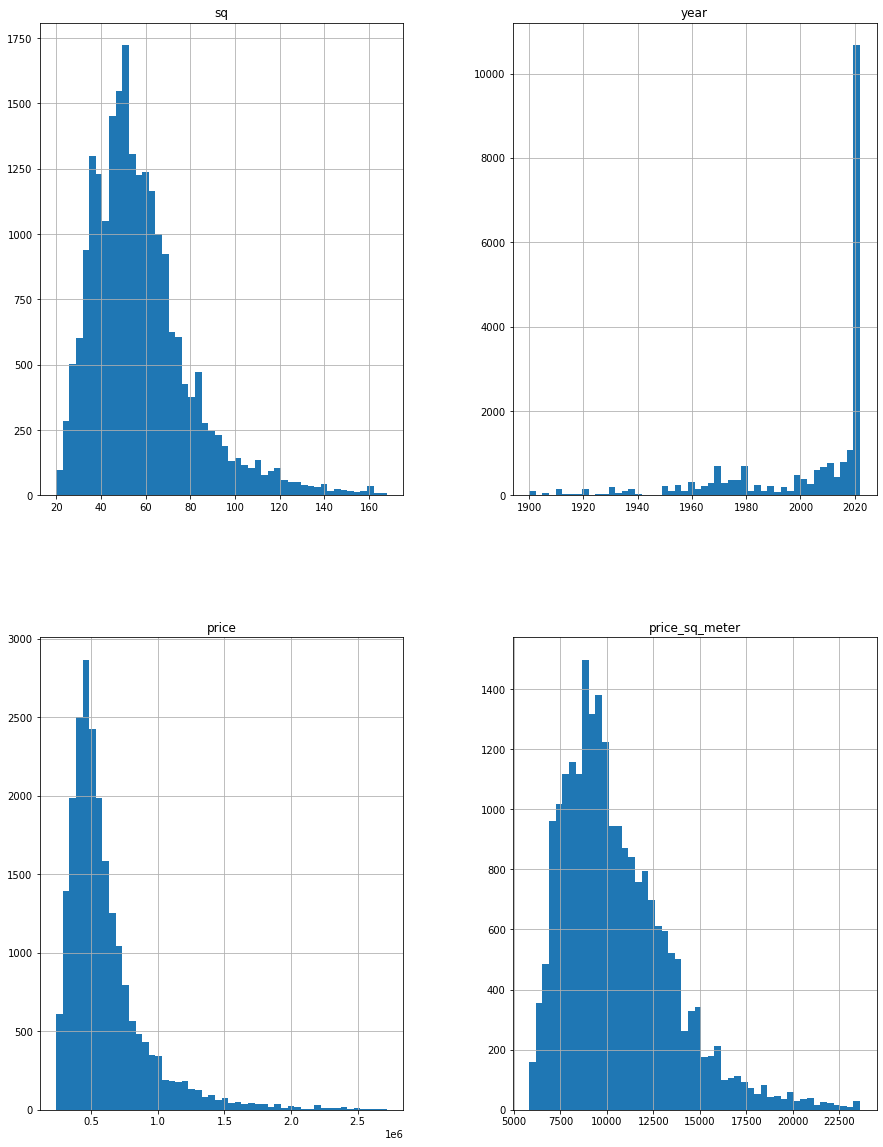

In [30]:
## Let's run the same code for detecting outliers but now let's also add price_sq_meters and visualize it

## I think that for the price_sq_meter feature we can let upper bound be equal to the maximum value because 138,636 pln is not impossible for some really
## luxuary apartment and as for lower bounds I think that as discussed earlier the values below 2000 threshold
## are most likely just mistakes, so we will lower the lower bound to this value when we will finally be dropping those

non_outliers = (df[["sq", "year", "price", "price_sq_meter"]]
 .apply(lambda ser: ser.pipe(delete_outliers_quartile, 0.01, 0.99))
 .all(axis=1)
)
df[["sq", "year", "price", "price_sq_meter"]][non_outliers].hist(bins=50, figsize=(15, 20))

In [31]:
year_proper = [1800, 2030]
sq_proper = [20, 500]
## We will not drop data points on the price itself but we will do so based on price_sq_meter,
## which I think is a better thing to do
# price = 
price_sq_meter_proper = [2000, df["price_sq_meter"].max()]
boundries_dict = {"year": year_proper, "sq": sq_proper, "price_sq_meter": price_sq_meter_proper}

In [32]:
## Let's create a function that will do the boolean masking
def get_proper_data(df_, bounds_dict):
    boolean_mask = pd.Series(np.ones(df_.shape[0]).astype(bool))
    for name in df_:
        ser = df_[name]
        lower_bound, upper_bound = bounds_dict[name]
        boolean_mask &= (ser >= lower_bound) & (ser <= upper_bound)
    return boolean_mask

In [33]:
non_outlier_data_mask = df[[*boundries_dict.keys()]].pipe(get_proper_data, boundries_dict)
non_outlier_data_mask

0        True
1        True
2        True
3        True
4        True
         ... 
23624    True
23625    True
23626    True
23627    True
23628    True
Length: 23629, dtype: bool

In [34]:
## We've dropped 219 data points (not bad it's less than 1% of our initial data)
df.shape[0] - df[non_outlier_data_mask].shape[0]

219

In [35]:
## Now the numerical data is ready for further preprocessing like standarization
df_non_outlier = df[non_outlier_data_mask].reset_index(drop=True)
df_non_outlier

,address,city,floor,latitude,longitude,price,rooms,sq,year,price_sq_meter
0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0,10115.0
1,Praga-Południe Grochowska,Warszawa,3.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0,9867.0
2,Krowodrza Czarnowiejska,Kraków,2.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0,11541.0
3,Grunwald,Poznań,2.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0,7771.0
4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0,9486.0
...,...,...,...,...,...,...,...,...,...,...
23405,Stare Miasto Naramowice,Poznań,0.0,52.449649,16.949408,543000.0,4.0,77.00,2020.0,7052.0
23406,Włochy,Warszawa,4.0,52.186109,20.948438,910000.0,3.0,71.00,2017.0,12817.0
23407,Nowe Miasto Malta ul. Katowicka,Poznań,0.0,52.397345,16.961939,430695.0,3.0,50.67,2022.0,8500.0
23408,Podgórze Duchackie Walerego Sławka,Kraków,6.0,50.024231,19.959569,359000.0,2.0,38.86,2021.0,9238.0


<AxesSubplot:>

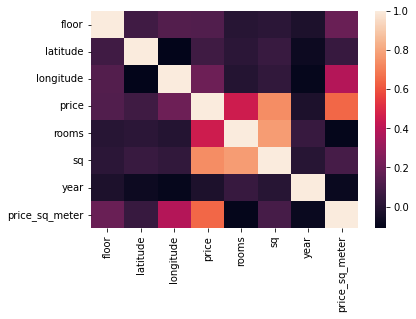

In [36]:
## Now let's see correlations between the features
import seaborn as sns
%matplotlib inline


# calculate the correlation matrix
corr = df_non_outlier.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
## Although the graph is helpful to see that some variables are more correlated than others let's check it systematically

In [37]:
def find_correlations_greater_than(correlations, threshold=0.7):
    
    row, col = np.where(correlations.abs() >= threshold)
    combine = np.concatenate((row[:, None], col[:, None]), axis=1)
    combinations = combine[(combine[:, 0] != combine[:, 1]) & (combine[:, 0] < combine[:, 1])]
    
    format_1 = "\"{}\" is correlated with \"{}\" with r = {}"
    
    left_side = correlations.columns[combinations[:, 0]]
    right_side = correlations.columns[combinations[:, 1]]
    r_side = correlations.to_numpy()[combinations[:, 0], combinations[:, 1]]
    three_sides = zip(left_side, right_side, r_side)
    for sides in three_sides:    
        print(format_1.format(*sides))


In [38]:
correlations = df_non_outlier.corr()
## Find correlations greater than threshold (obviously the correlations are mirrored across the diagonal)
## i.e. if a is correlated with b with r = 0.9 then b is correlated with a with the same r therefore I won't print the second statement

## We also see that the "sq" feature is quite strongly correlated with the price(target variable) which is good
## But unfortunately it is also quite strongly correlated with another feature (high correlations between features signifies that
## one feature can be explained by the another which does not bring a lot of information therefore it is not considered to be desirable)
find_correlations_greater_than(correlations, threshold=0.5)

"price" is correlated with "sq" with r = 0.7369823019723841
"price" is correlated with "price_sq_meter" with r = 0.6460674889801342
"rooms" is correlated with "sq" with r = 0.7744953319992672


In [39]:
## Let's also check correlations without dropping the outliers

<AxesSubplot:>

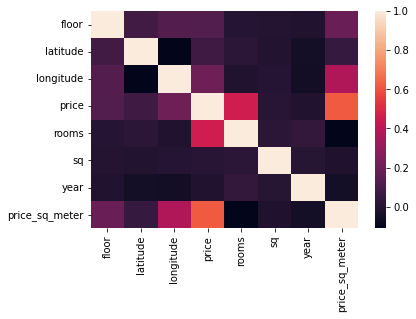

In [40]:
## Now let's see correlations between the features without preprocessing
import seaborn as sns
%matplotlib inline


# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [41]:
## No outlier deletion
correlations1 = df.corr()
find_correlations_greater_than(correlations1, threshold=0.5)

"price" is correlated with "price_sq_meter" with r = 0.6182741865455833


In [42]:
## outlier deletion
find_correlations_greater_than(correlations, threshold=0.5)

"price" is correlated with "sq" with r = 0.7369823019723841
"price" is correlated with "price_sq_meter" with r = 0.6460674889801342
"rooms" is correlated with "sq" with r = 0.7744953319992672


In [43]:
## As we can see the deletion of the outliers yielded quite a good results because
## the features are more correlated with the target variable
## And the correlations within features are more visible now
## (if the correlation would be higher than 0.8 or 0.9 we could consider deleting the correlated feature
## because it would be easily predicted by another) which might be decisive for dropping the highly correlated features columns

## Now that we are done with the first part (most tedious part) of preprocessing numerical data we can go right to the string data

In [44]:
pd.concat([df.nunique(), df.dtypes], axis=1).rename({0: "Unique Count", 1: "Data Type"}, axis=1)

,Unique Count,Data Type
address,5358,object
city,3,object
floor,11,float64
latitude,2740,float64
longitude,2741,float64
price,7265,float64
rooms,10,float64
sq,5005,float64
year,168,float64
price_sq_meter,7537,float64


### The first thing that comes to mind is to reduce the number of addresses which will be useful for One Hot Encoding and better generalization, because it's quite unlikely that the sample size for every street in every city will be high enough to obtain meaningful results
### But before all of this let's firstly normalize the string columns (["address", "city"]) because there might be different spelling of the same address/city or simply different capitalization which should be identified as being equal but they won't without normalization

In [45]:
df.address.str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")

0                   Podgorze Zabocie Stanisawa Klimeckiego
1                                 Praga-Poudnie Grochowska
2                                  Krowodrza Czarnowiejska
3                                                 Grunwald
4        Ochota Gotowy budynek. Stan deweloperski. Osta...
                               ...                        
23624                              Stare Miasto Naramowice
23625                                                Wochy
23626                      Nowe Miasto Malta ul. Katowicka
23627                    Podgorze Duchackie Walerego Sawka
23628                                              Ursynow
Name: address, Length: 23629, dtype: object

In [46]:
## Something's not right here, some characters like "ó" are changed to "o" and some like "ł" completely disappear
## Let's check what's happening with all polish characters
series_polish_special_characters = pd.Series(data=list("ąćęłńóśźż"))
polish_series_after = series_polish_special_characters.str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
comparison_series = pd.concat([series_polish_special_characters, polish_series_after], axis=1)
comparison_series.rename({0: "Polish character", 1: "Transformed Character"}, axis=1)

,Polish character,Transformed Character
0,ą,a
1,ć,c
2,ę,e
3,ł,
4,ń,n
5,ó,o
6,ś,s
7,ź,z
8,ż,z


### Apparently only ł transformation does not work os let's replace it (ł) simply with l

In [47]:
(df.address
 .str.lower()
 .str.replace("ł", "l")
 .str.normalize("NFKD")
 .str.encode("ascii", errors="ignore")
 .str.decode("utf-8")
)

0                 podgorze zablocie stanislawa klimeckiego
1                                praga-poludnie grochowska
2                                  krowodrza czarnowiejska
3                                                 grunwald
4        ochota gotowy budynek. stan deweloperski. osta...
                               ...                        
23624                              stare miasto naramowice
23625                                               wlochy
23626                      nowe miasto malta ul. katowicka
23627                   podgorze duchackie walerego slawka
23628                                              ursynow
Name: address, Length: 23629, dtype: object

In [48]:
## Now that we have blueprints for our function lets write it as a such, for cleaner code and reusability
## (which maybe here isn't that visible to appear but when working on multiple projects within
## the domain of polish language the use of such function would probably appear more than once)
def normalize_string_columns(ser):
    return (ser
          .str.lower()
          .str.replace("ł", "l")
          .str.normalize("NFKD")
          .str.encode("ascii", errors="ignore")
          .str.decode("utf-8")
          )

In [49]:
## As it can be seen 37 addresses were "duplicated" in a sense that after the normalization they stopped being unique
df.select_dtypes("object").nunique() - df.select_dtypes("object").apply(lambda x: normalize_string_columns(x)).nunique()

address    37
city        0
dtype: int64

In [50]:
df.select_dtypes("object") 

,address,city
0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków
1,Praga-Południe Grochowska,Warszawa
2,Krowodrza Czarnowiejska,Kraków
3,Grunwald,Poznań
4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa
...,...,...
23624,Stare Miasto Naramowice,Poznań
23625,Włochy,Warszawa
23626,Nowe Miasto Malta ul. Katowicka,Poznań
23627,Podgórze Duchackie Walerego Sławka,Kraków


In [51]:
df.select_dtypes("object").apply(lambda x: normalize_string_columns(x))

,address,city
0,podgorze zablocie stanislawa klimeckiego,krakow
1,praga-poludnie grochowska,warszawa
2,krowodrza czarnowiejska,krakow
3,grunwald,poznan
4,ochota gotowy budynek. stan deweloperski. osta...,warszawa
...,...,...
23624,stare miasto naramowice,poznan
23625,wlochy,warszawa
23626,nowe miasto malta ul. katowicka,poznan
23627,podgorze duchackie walerego slawka,krakow


In [52]:
df[["address", "city"]] = df.select_dtypes("object").apply(lambda x: normalize_string_columns(x))
df

,address,city,floor,latitude,longitude,price,rooms,sq,year,price_sq_meter
0,podgorze zablocie stanislawa klimeckiego,krakow,2.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0,10115.0
1,praga-poludnie grochowska,warszawa,3.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0,9867.0
2,krowodrza czarnowiejska,krakow,2.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0,11541.0
3,grunwald,poznan,2.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0,7771.0
4,ochota gotowy budynek. stan deweloperski. osta...,warszawa,1.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0,9486.0
...,...,...,...,...,...,...,...,...,...,...
23624,stare miasto naramowice,poznan,0.0,52.449649,16.949408,543000.0,4.0,77.00,2020.0,7052.0
23625,wlochy,warszawa,4.0,52.186109,20.948438,910000.0,3.0,71.00,2017.0,12817.0
23626,nowe miasto malta ul. katowicka,poznan,0.0,52.397345,16.961939,430695.0,3.0,50.67,2022.0,8500.0
23627,podgorze duchackie walerego slawka,krakow,6.0,50.024231,19.959569,359000.0,2.0,38.86,2021.0,9238.0


### Now let's try to reduce the number of addresses that occur within a given city

### The naming of the function isn't a coincidence here because I'd like to emphasize that it probably would not be wise to delete the information about in which city the given flat/house/appartment is located 
### Because in the housing market the localization is key e.g. houses in Warszawa will cost much more than houses in Wągrowiec, solely based on the fact of their location (I think that the city information is more important than address information for determining the price of a flat/house/apartment)

In [53]:
## One functions takes the top frac percent of the given "population" 
def reduce_addresses_frac(ser, frac=0.9, other="Other"):
    top_frac = ser.value_counts() / ser.size
    top_frac = top_frac.cumsum()
    bool_series = top_frac > frac
    if bool_series.sum() >= 1:
        end_point = bool_series.argmax() + 1
        return ser.where(ser.isin(top_frac.index[:end_point]), other)
    return ser

## The second function changes every value that's below n number of occurances to value of other

def reduce_address_number(ser, n, other="Other"):
    top_n = ser.value_counts()
    bool_mask = top_n >= n
    values = top_n[bool_mask].index
    
    return ser.where(ser.isin(values), other)

In [54]:
not_groupped_reduce = df.address.pipe(reduce_addresses_frac, 0.9, "Other")
not_groupped_reduce

0                 podgorze zablocie stanislawa klimeckiego
1                                praga-poludnie grochowska
2                                  krowodrza czarnowiejska
3                                                 grunwald
4        ochota gotowy budynek. stan deweloperski. osta...
                               ...                        
23624                              stare miasto naramowice
23625                                               wlochy
23626                      nowe miasto malta ul. katowicka
23627                   podgorze duchackie walerego slawka
23628                                              ursynow
Name: address, Length: 23629, dtype: object

In [55]:
groupped_reduce = df.groupby("city")["address"].apply(lambda x: x.pipe(reduce_addresses_frac, 0.9, "Other"))
groupped_reduce.nunique()

2964

In [56]:
final = df.groupby("city")["address"].apply(lambda x: x.pipe(reduce_address_number, 20, "Other"))
final

0        podgorze zablocie stanislawa klimeckiego
1                       praga-poludnie grochowska
2                                           Other
3                                        grunwald
4                                           Other
                           ...                   
23624                     stare miasto naramowice
23625                                      wlochy
23626             nowe miasto malta ul. katowicka
23627          podgorze duchackie walerego slawka
23628                                     ursynow
Name: address, Length: 23629, dtype: object

## The comparison 

In [57]:
union = len(set(not_groupped_reduce).union(set(groupped_reduce)))
union

3314

In [58]:
## Let's check how many addresses repeat themselves between the groups
intersection = len(set(not_groupped_reduce).intersection(set(groupped_reduce)))
intersection

2610

In [59]:
## Let's use xor to check which addresses are different within those two reduces
xor = len(set(not_groupped_reduce).symmetric_difference(set(groupped_reduce)))
xor

704

In [60]:
## Obviously union = xor + intersection
union == xor + intersection

True

In [61]:
df.city.value_counts()

warszawa    9828
krakow      9705
poznan      4096
Name: city, dtype: int64

### Here grouped_reduce in my opinion will be more beneficial because it targets the addresses within a given city which probably is more imprtant than a global target(here it's probably not that big of a deal because we have 3 cities that have quite similar value counts but if we would have tens / hundreds of cities then we would not have the information about addresses within the smaller cities or have it simply by chance because they occur in many cities or in few big ones)
### So the conclusion is we'll stick with the groupped_reduce series for addresses

### !!! Actually I think that taking only values that occur a certain number of time is far better strategy that taking the top fraction

In [62]:
groupped_reduce

0                 podgorze zablocie stanislawa klimeckiego
1                                praga-poludnie grochowska
2                                  krowodrza czarnowiejska
3                                                 grunwald
4        ochota gotowy budynek. stan deweloperski. osta...
                               ...                        
23624                              stare miasto naramowice
23625                                               wlochy
23626                      nowe miasto malta ul. katowicka
23627                   podgorze duchackie walerego slawka
23628                                              ursynow
Name: address, Length: 23629, dtype: object

In [63]:
## Difference between the number of unique addresses before reduction and after
df.address.nunique() - groupped_reduce.nunique()

2357

In [64]:
df.address = final

In [65]:
df.head()

,address,city,floor,latitude,longitude,price,rooms,sq,year,price_sq_meter
0,podgorze zablocie stanislawa klimeckiego,krakow,2.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0,10115.0
1,praga-poludnie grochowska,warszawa,3.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0,9867.0
2,Other,krakow,2.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0,11541.0
3,grunwald,poznan,2.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0,7771.0
4,Other,warszawa,1.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0,9486.0


## Now we can focus more on the "easy" part of preprocessing which will be One Hot Encoding and Standarization

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [67]:
## Before we will use any model we will first have to delete the "price_sq_meter" column because with combination with "sq" column
## it gives the exact price of the house. This("price_sq_meter") column was only used to delete some outliers and get better inisight
## of the data
df = df.drop(columns=["price_sq_meter"])

In [68]:
## Now it's the time to split the data
## The two lines below were used to simple training and testing, but now I'm using cross validation to get more accurate
## results from the models(with different random_states the models gave different results by even 0.05)
## Probably k-fold cross validation would be better, but the computational power available would make it difficult to use it

In [69]:
# X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["price", "address"]), df["price"], test_size=0.2, random_state=42)

In [70]:
# X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df.drop(columns=["price"]), df["price"], test_size=0.2, random_state=42)

In [71]:
nominal_transformer = Pipeline(steps=[
    ("one_hot", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

preprocessor_0 = ColumnTransformer(transformers=[
    ("nominal", nominal_transformer, ["city"]),
], remainder="passthrough")


pipeline_0 = Pipeline(steps=[
    ("preprocessor", preprocessor_0),
    ("scaler", StandardScaler()),
])




preprocessor_1 = ColumnTransformer(transformers=[
    ("nominal", nominal_transformer, ["city", "address"]),
], remainder="passthrough")


pipeline_1 = Pipeline(steps=[
    ("preprocessor", preprocessor_1),
    ("scaler", StandardScaler()),
])




In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [87]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGB Regressor": XGBRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}


In [95]:

## Maybe the naming isn't most appropriate but those X_trains are then splited in the cross_validate into train and validate set
X_trains = [df.drop(columns=["price", "address"]), df.drop(columns=["price"])]
y_trains = [df["price"], df["price"]]

names = ["Dataset without addresses", "Dataset with addresses"]
metrics_names = ["r2", "MAE", "RMSE", "Max Error"]

combine = {name: dict() for name in names}
for i in range(2):

    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGB Regressor": XGBRegressor(random_state=42),
        "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
    }

    print(f"{names[i]}:")

    if i == 0:
        X_train_piped = pipeline_0.fit_transform(X_trains[i])
    else:
        X_train_piped = pipeline_1.fit_transform(X_trains[i])
    
    for name_model, model in models.items():
        
        
        values = cross_validate(model, X_train_piped, y_trains[i], scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error", "max_error"), cv=5)

        ## if the number of metrics would be bigger the loop would be advisible, but now this solution seems more readable
        r2 = values["test_r2"].mean()
        mae = values["test_neg_mean_absolute_error"].mean() * -1
        rmse = np.sqrt(values["test_neg_mean_squared_error"] * -1).mean() 
        max_error = values["test_max_error"].mean() * -1

        combine[names[i]][name_model] = dict(zip(metrics_names, [r2, mae, rmse, max_error]))

        print(f"{name_model} R^2 score: {r2:.4f}")
        # print(f"{name}  MAE: {mae:.4f}")
        # print(f"{name}  RMSE: {rmse:.4f}")
        # print(f"{name} Max Error: {max_error}")
    print()


Dataset without addresses:
Linear Regression R^2 score: -69.6807
Decision Tree R^2 score: 0.6669
Random Forest R^2 score: 0.8265
XGB Regressor R^2 score: 0.8365
Gradient Boosting Regressor R^2 score: 0.7903

Dataset with addresses:
Linear Regression R^2 score: -54.3056
Decision Tree R^2 score: 0.7219
Random Forest R^2 score: 0.8251
XGB Regressor R^2 score: 0.8257
Gradient Boosting Regressor R^2 score: 0.7890



In [96]:
combine["Dataset without addresses"]["Linear Regression"]

{'r2': -69.68073436424274,
 'MAE': 251969.7760386446,
 'RMSE': 2319739.8365592677,
 'Max Error': 142850703.4600982}

In [97]:
multi_index = [(outer1, outer2, outer3) for outer1 in combine.keys() for outer2 in combine[outer1].keys() for outer3 in combine[outer1][outer2].keys()]
multi_index_values = [outer3 for outer1 in combine.keys() for outer2 in combine[outer1].keys() for outer3 in combine[outer1][outer2].values()]

In [98]:
pd_multi_index = pd.MultiIndex.from_tuples(multi_index)

In [99]:
df_metrics = pd.DataFrame(index=pd_multi_index, data=multi_index_values).apply(lambda x: '%.3f' % x, axis=1).to_frame().rename({0: "Value"}, axis=1)
df_metrics.swaplevel(0, 2).swaplevel(0, 1).sort_index()

Value
Decision Tree               MAE       Dataset with addresses         86021.581
                                      Dataset without addresses      85530.860
                            Max Error Dataset with addresses       6458240.000
                                      Dataset without addresses    8550905.000
                            RMSE      Dataset with addresses        280232.963
                                      Dataset without addresses     304279.715
                            r2        Dataset with addresses             0.722
                                      Dataset without addresses          0.667
Gradient Boosting Regressor MAE       Dataset with addresses        102379.707
                                      Dataset without addresses     102456.563
                            Max Error Dataset with addresses       6452010.432
                                      Dataset without addresses    6204280.841
                            RMSE      Dataset with addresses        244059.420
                                      Dataset without addresses     243276.594
                            r2        Dataset with addresses             0.789
                                      Dataset without addresses          0.790
Linear Regression           MAE       Dataset with addresses        229517.320
                                      Dataset without addresses     251969.776
                            Max Error Dataset with addresses     126548639.707
                                      Dataset without addresses  142850703.460
                            RMSE      Dataset with addresses       2062816.914
                                      Dataset without addresses    2319739.837
                            r2        Dataset with addresses           -54.306
                                      Dataset without addresses        -69.681
Random Forest               MAE       Dataset with addresses         71387.147
                                      Dataset without addresses      71198.184
                            Max Error Dataset with addresses       6450794.733
                                      Dataset without addresses    5963618.584
                            RMSE      Dataset with addresses        222303.704
                                      Dataset without addresses     221036.176
                            r2        Dataset with addresses             0.825
                                      Dataset without addresses          0.826
XGB Regressor               MAE       Dataset with addresses         82395.157
                                      Dataset without addresses      79751.529
                            Max Error Dataset with addresses       6546661.350
                                      Dataset without addresses    6223986.125
                            RMSE      Dataset with addresses        221337.076
                                      Dataset without addresses     213719.418
                            r2        Dataset with addresses             0.826
                                      Dataset without addresses          0.837

## Conclusions:

1. Random Forest in both cases have smaller Mean Absolute Error than XGB Regressor which has better R^2 score and RMSE score which means that the first classifier is getting the general trend better(because MAE does not punish so heavely the missclasified outliers as RMSE does)
2. I think that two classifiers or even more should be made to accomodate the great variance between the housing prices e.g. One type of classifier(s) should be fitted on a data with prices lower than let's say 1,000,000 zł(90th percentile) the second should be fitted on the data with prices between(90th and 95th percentile for example) and the third should accomodate the rest of the data(obviously this would work only if we would have more information on the houses themselves like luxury_status, prestige etc. but now the existing values are not giving enough information to accomodate the outliers, because on the feature side of things they are not that different from the regular house/flat.
3. There isn't that much different between dataset with or without the addresses, maybe apart from the Decision Tree classifier which has significantly higher R^2 score
4. Final remark, I think that it would be beneficial to try to reduce the market to the 90th percentile(1,000,000 zł for flat/house/apartment) with one solution and the rest(luxuary estates nonetheless) with some other(probably not machine learning one because there most likely wouldn't be enough (quality) data for it)

In [100]:
price_90th_percentile = df["price"].quantile(0.9)

In [101]:
print(f"90% of the houses in this dataset are below {round(price_90th_percentile)} zł")

90% of the houses in this dataset are below 1013914 zł


In [102]:
## We might also check our thoughts just to ensure that our thoughts were correct(3rd point)

df_copy = df.copy()
df_copy = df_copy[df_copy["price"] <= price_90th_percentile]

In [103]:
X_trains = [df_copy.drop(columns=["price", "address"]), df_copy.drop(columns=["price"])]
y_trains = [df_copy["price"], df_copy["price"]]


combine = {name: dict() for name in names}
for i in range(2):

    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGB Regressor": XGBRegressor(random_state=42),
        "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
    }

    print(f"{names[i]}:")

    if i == 0:
        X_train_piped = pipeline_0.fit_transform(X_trains[i])
    else:
        X_train_piped = pipeline_1.fit_transform(X_trains[i])
    
    for name_model, model in models.items():
        
        
        values = cross_validate(model, X_train_piped, y_trains[i], scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error", "max_error"), cv=5)

        ## if the number of metrics would be bigger the loop would be advisible, but now this solution seems more readable
        r2 = values["test_r2"].mean()
        mae = values["test_neg_mean_absolute_error"].mean() * -1
        rmse = np.sqrt(values["test_neg_mean_squared_error"] * -1).mean() 
        max_error = values["test_max_error"].mean() * -1

        combine[names[i]][name_model] = dict(zip(metrics_names, [r2, mae, rmse, max_error]))

        print(f"{name_model} R^2 score: {r2:.4f}")
        # print(f"{name}  MAE: {mae:.4f}")
        # print(f"{name}  RMSE: {rmse:.4f}")
        # print(f"{name} Max Error: {max_error}")
    print()

Dataset without addresses:
Linear Regression R^2 score: -12.4374
Decision Tree R^2 score: 0.7590
Random Forest R^2 score: 0.8723
XGB Regressor R^2 score: 0.8668
Gradient Boosting Regressor R^2 score: 0.7953

Dataset with addresses:
Linear Regression R^2 score: -6925712710109558210560.0000
Decision Tree R^2 score: 0.7755
Random Forest R^2 score: 0.8749
XGB Regressor R^2 score: 0.8581
Gradient Boosting Regressor R^2 score: 0.7917



In [105]:
multi_index1 = [(outer1, outer2, outer3) for outer1 in combine.keys() for outer2 in combine[outer1].keys() for outer3 in combine[outer1][outer2].keys()]
multi_index_values1 = [outer3 for outer1 in combine.keys() for outer2 in combine[outer1].keys() for outer3 in combine[outer1][outer2].values()]

In [106]:
pd_multi_index1 = pd.MultiIndex.from_tuples(multi_index1)

In [107]:
df_metrics = pd.DataFrame(index=pd_multi_index1, data=multi_index_values1).apply(lambda x: '%.3f' % x, axis=1).to_frame().rename({0: "Value"}, axis=1)
df_metrics.swaplevel(0,2).swaplevel(0,1).sort_index()

Value
Decision Tree               MAE       Dataset with addresses                       45027.657
                                      Dataset without addresses                    45915.733
                            Max Error Dataset with addresses                      556922.000
                                      Dataset without addresses                   615505.800
                            RMSE      Dataset with addresses                       82885.201
                                      Dataset without addresses                    85859.309
                            r2        Dataset with addresses                           0.776
                                      Dataset without addresses                        0.759
Gradient Boosting Regressor MAE       Dataset with addresses                       56851.668
                                      Dataset without addresses                    56143.710
                            Max Error Dataset with addresses                      535981.786
                                      Dataset without addresses                   540440.259
                            RMSE      Dataset with addresses                       79856.467
                                      Dataset without addresses                    79164.668
                            r2        Dataset with addresses                           0.792
                                      Dataset without addresses                        0.795
Linear Regression           MAE       Dataset with addresses              99440089434197.484
                                      Dataset without addresses                   107804.245
                            Max Error Dataset with addresses          422918699981419840.000
                                      Dataset without addresses                 18765222.954
                            RMSE      Dataset with addresses            6484988304723372.000
                                      Dataset without addresses                   387731.796
                            r2        Dataset with addresses     -6925712710109558210560.000
                                      Dataset without addresses                      -12.437
Random Forest               MAE       Dataset with addresses                       37040.484
                                      Dataset without addresses                    37332.689
                            Max Error Dataset with addresses                      518423.467
                                      Dataset without addresses                   525648.161
                            RMSE      Dataset with addresses                       61881.554
                                      Dataset without addresses                    62505.398
                            r2        Dataset with addresses                           0.875
                                      Dataset without addresses                        0.872
XGB Regressor               MAE       Dataset with addresses                       44390.748
                                      Dataset without addresses                    42791.901
                            Max Error Dataset with addresses                      534738.606
                                      Dataset without addresses                   520973.056
                            RMSE      Dataset with addresses                       65918.009
                                      Dataset without addresses                    63865.712
                            r2        Dataset with addresses                           0.858
                                      Dataset without addresses                        0.867

In [108]:
## The results shouldn't be surprising the scores are much better, now Random Forests classifiers are below 40,000 zł MAE mark
## and the RMSE isn't that much bigger
## It's hard for me to explain the R^2 score for Linear Regression on a dataset that contains the addresses, maybe it's because of some sort of overfitting
## but either way it should not give Max Error on the scale of bilions of bilions, either way it's kinda of an enigma to me ¯\_(ツ)_/¯